### Kaniela Denis & Daniel Northcutt
    01/31/2022

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

from env import host, user, password

# DBSCAN import
from sklearn.cluster import DBSCAN

import acquire
import prepare

In [2]:
#acquire sql query
df = acquire.acquire()

In [3]:
# see prepare for cleaning
df = prepare.clean_cohort(df)

In [4]:
# splits our df into a webdev and data science
df_wd, df_ds = prepare.program_split(df)

## Prepare
   #### Prepare Summary:
   - Acquired data from SQL server and saved locally on csv
   - Dropped unecessary columns
   - Removed staff from database
   - Defined program id as either web_dev or data_science
   - Removed nulls
   - Grouped course material into lesson column
   - Creatd url and subpath column by removing \ from path
   - Created a counter column to help aid in ip hits
   - Split data between df_wd (webdev) & df_ds (data science) 

<hr style="border:1px solid black"> </hr>


## 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [5]:
# DS Lessons count from top
df_ds.groupby('lesson')[['user_id']].agg('count').sort_values(by='user_id', ascending=False).head(6)

,user_id
lesson,
fundamentals,16691
sql,13685
classification,11841
python,10492
regression,7471
stats,6663


In [6]:
# see counts for web dev lessons from top
df_wd.groupby('lesson')[['user_id']].agg('count').sort_values(by='user_id', ascending=False).head(6)

,user_id
lesson,
javascript,149227
java,138797
html-css,92725
mysql,71913
pending,58279
spring,52344


## 5 Most Popular Lessons for Data Science
- Fundamentals
- SQL
- Classfication
- Python
- Regression



## 5 Most Popular Lessons for Web Dev
- Javascript
- Java
- HTML-CSS
- MySQL
- Spring


<hr style="border:1px solid black"> </hr>


## 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

In [7]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [8]:
df_lessons = value_counts_and_frequencies(df_wd.lesson)
df_lessons.head(60)

,count,proba
javascript,149227,0.226140
java,138797,0.210334
html-css,92725,0.140516
mysql,71913,0.108978
pending,58279,0.088317
spring,52344,0.079323
jquery,50290,0.076210
toc,16669,0.025260
search,16000,0.024247
capstone,4834,0.007325


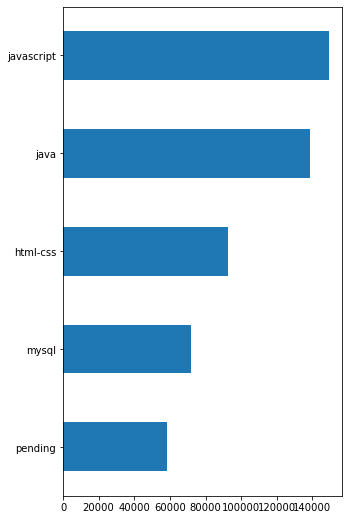

In [9]:
df_lessons['count'].sort_values().tail(5).plot.barh(figsize=(5, 9));

In [10]:
# groupby lesson, then groupby cohort, count user_id
webdev_lessons = df_wd.groupby(['lesson','name'])[['user_id']].agg('count').sort_values(['user_id'], ascending=False).reset_index()
webdev_lessons.head(20)

,lesson,name,user_id
0,java,Jupiter,9594
1,javascript,Ceres,9359
2,javascript,Zion,8754
3,java,Voyageurs,8617
4,java,Ceres,8612
5,java,Fortuna,8485
6,java,Apex,8291
7,java,Zion,8219
8,java,Ganymede,7649
9,javascript,Fortuna,7450


In [11]:
webdev_lessons = webdev_lessons.rename(columns={'user_id':'count'})
webdev_lessons['cohort_lesson'] = webdev_lessons.name + '_' + webdev_lessons.lesson
webdev_lessons

,lesson,name,count,cohort_lesson
0,java,Jupiter,9594,Jupiter_java
1,javascript,Ceres,9359,Ceres_javascript
2,javascript,Zion,8754,Zion_javascript
3,java,Voyageurs,8617,Voyageurs_java
4,java,Ceres,8612,Ceres_java
...,...,...,...,...
475,capstone,Ike,1,Ike_capstone
476,fundamentals,Yosemite,1,Yosemite_fundamentals
477,capstone,Niagara,1,Niagara_capstone
478,search,Ike,1,Ike_search


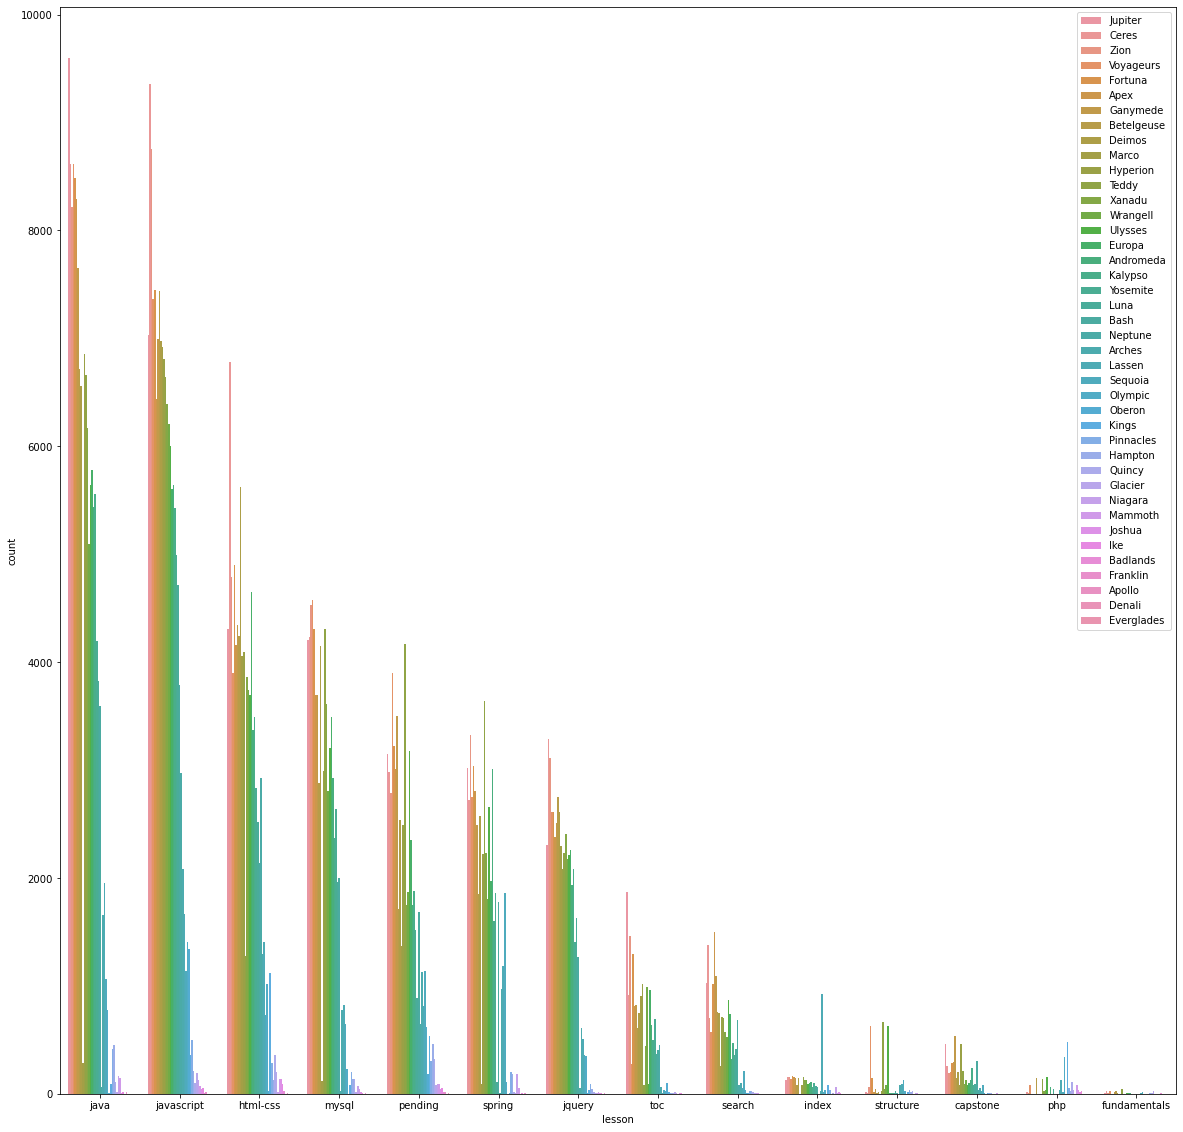

In [12]:
plt.figure(figsize=(20, 20))
sns.barplot(data=webdev_lessons, x='lesson', y='count', hue='name')
plt.legend(loc=1)

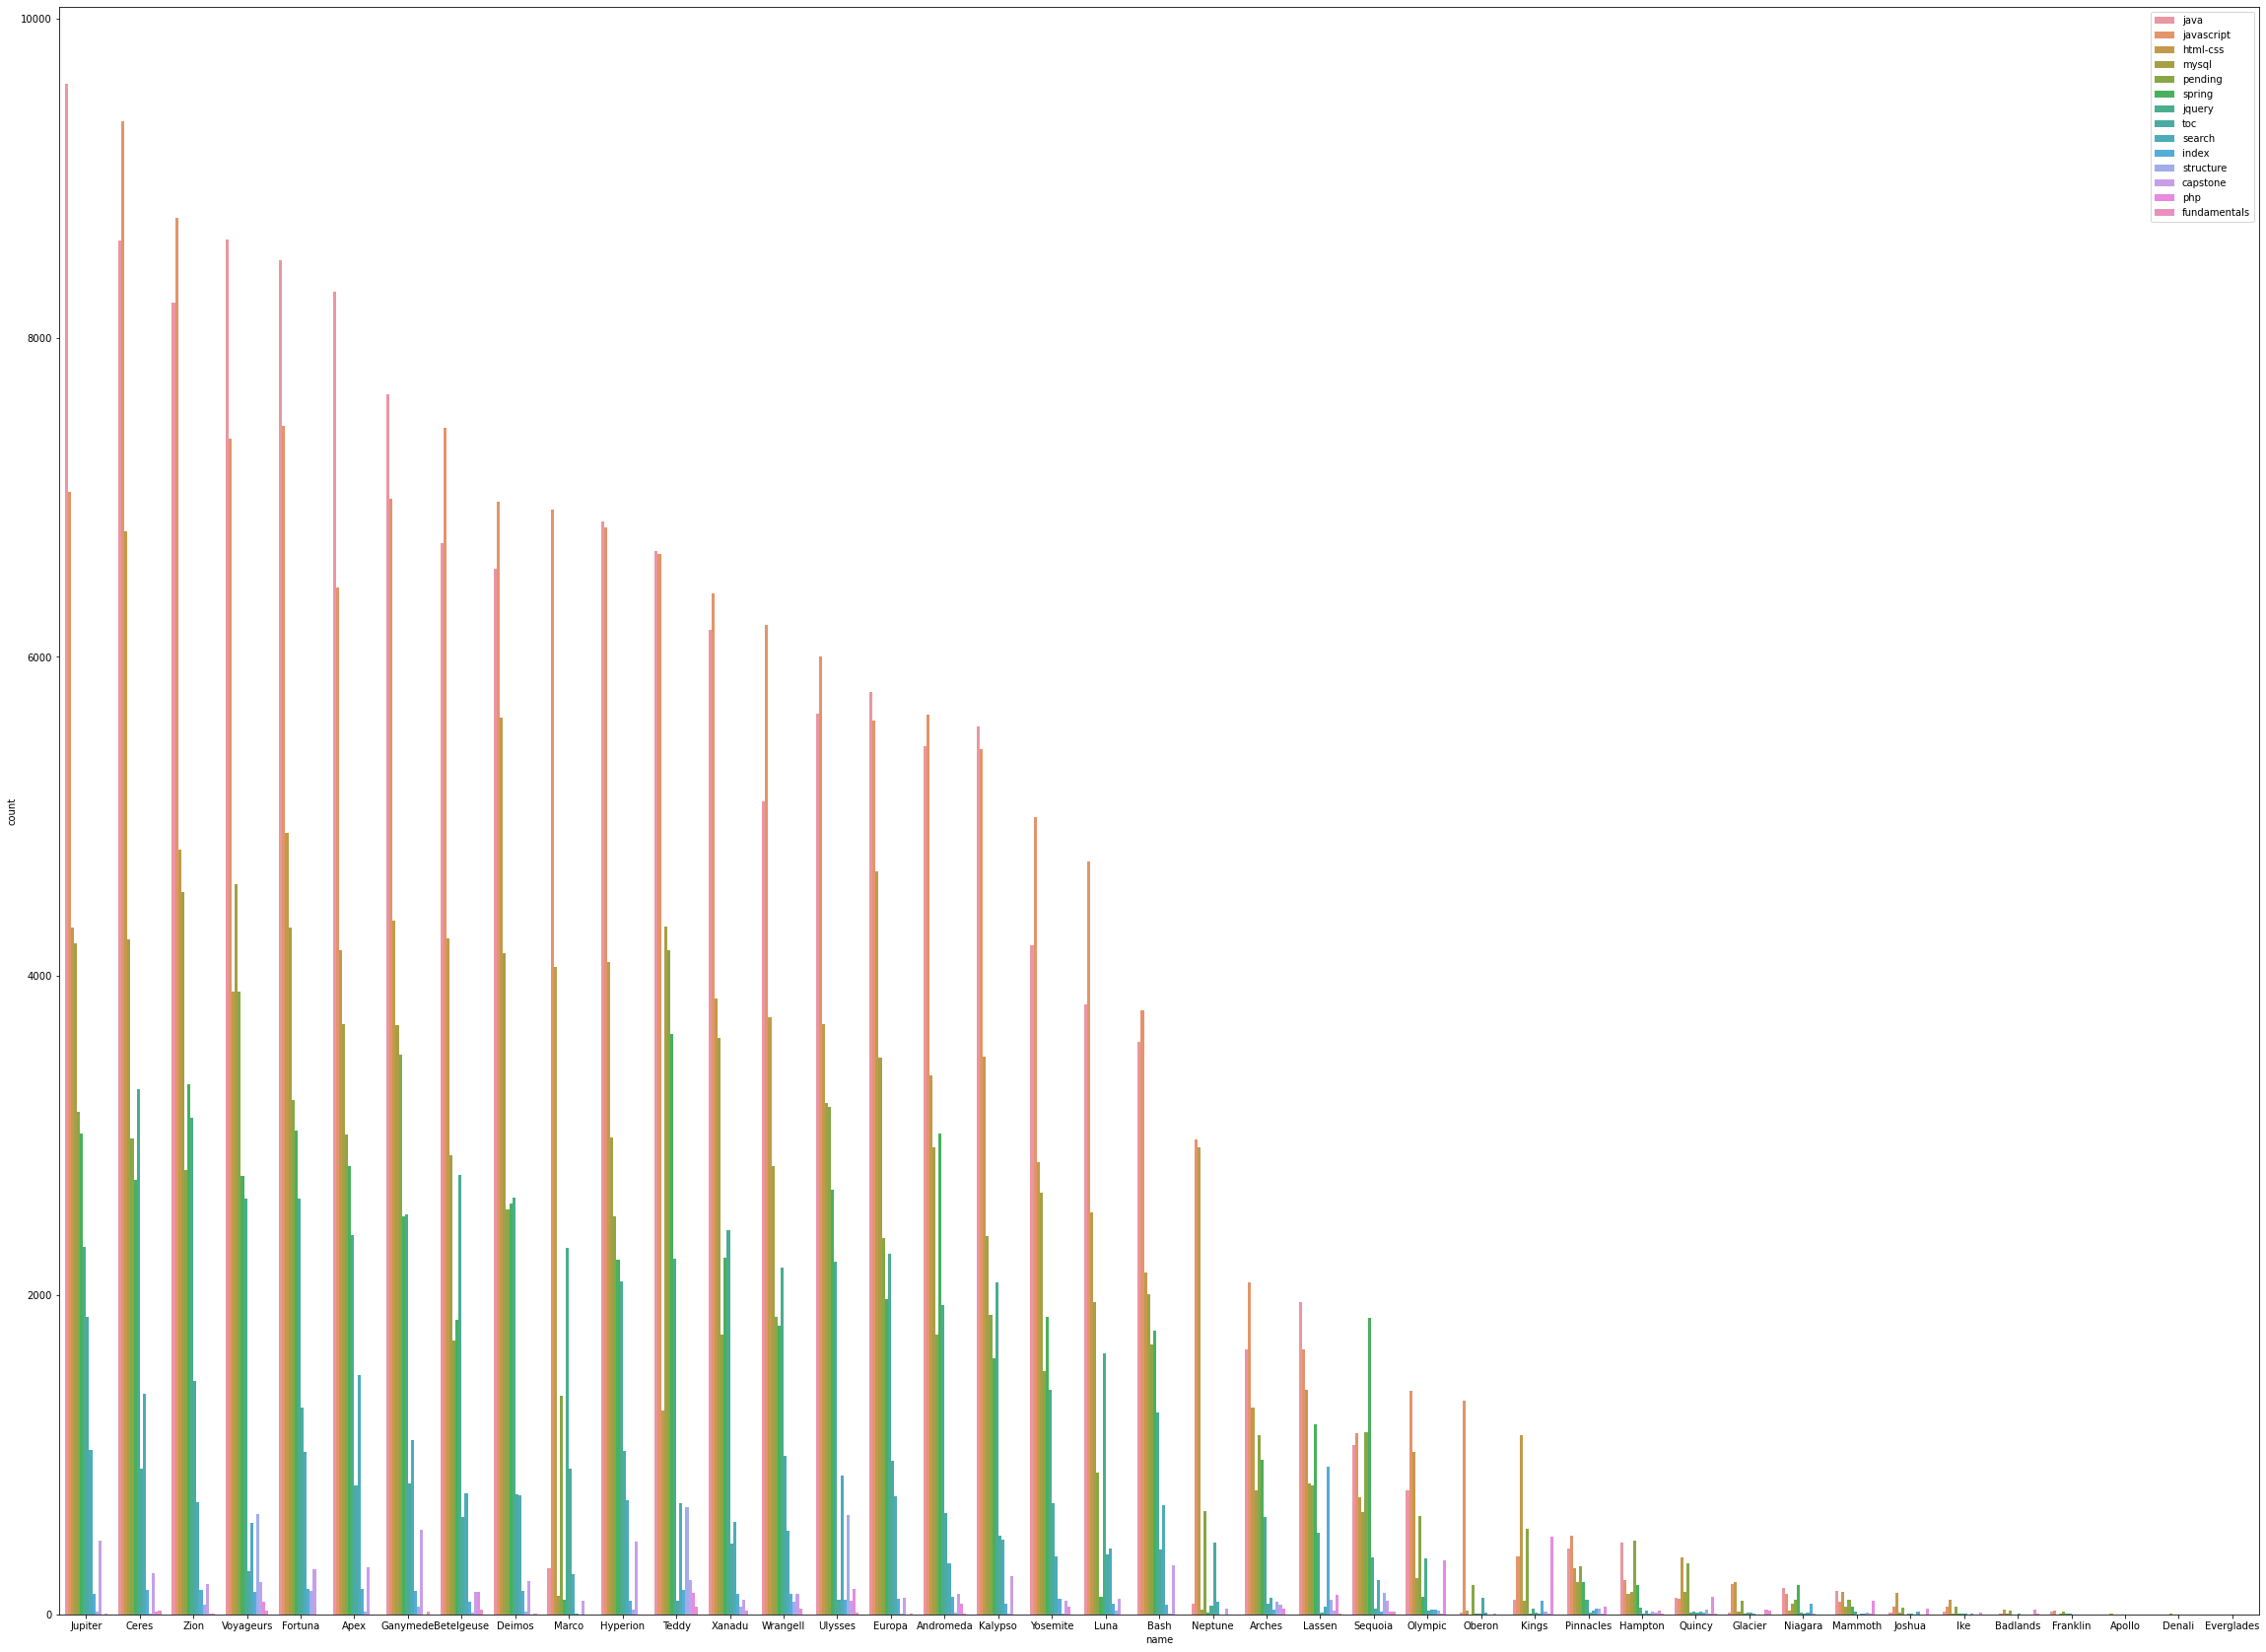

In [13]:
plt.figure(figsize=(40, 30))
sns.barplot(data=webdev_lessons, x='name', y='count', hue='lesson')
plt.legend(loc=1)

<hr style="border:1px solid black"> </hr>


## 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [14]:
# represents students when active in their cohort
df_active = df[(df.start_date <= df.date) & (df.date <= df.end_date)]
df_active.shape

(647495, 15)

In [15]:
# active students groupby the user_id giving a sum on the counter column
student_counter = (df_active.groupby('user_id').counter.sum().sort_values())
#make into a dataframe
student_counter=pd.DataFrame(student_counter)

In [16]:
student_counter

,counter
user_id,
918,1
879,1
940,1
619,1
832,3
...,...
555,3088
671,3194
685,3224


In [17]:
# this represents that the lowest 20% of student's curriculum searches is under 288 vists
bottom_twenty = student_counter.counter.quantile(.20)
bottom_twenty

288.0

In [18]:
# this represents that the highest 20% of student's curriculum searches is over 1379 vists
top_twenty = student_counter.counter.quantile(.80)
top_twenty

1379.0

In [19]:
# the last date stamp from this database is on: 
df.date.max()

'2021-04-21'

- The top 20% student curriculum searches was >= 1379
- The lowest 20% student curriculum searches was <= 288



#### The last date stamp of this dataframe is on 04-21-2021


These 5 cohorts are not accurately represented by the dataset as their end date for students is beyond the last entry from this dataset

 End Date: ---- Cohort Name: --- Ip hits:
 
2021-05-04 ---- Kalypso   ----    23691

2021-06-08 ---- Luna     ----     16623

2021-07-19 ---- Marco    ----     16397

2021-09-03 ---- Neptune    ----    7276

2021-10-01 ---- Oberon   ----      1672

<hr style="border:1px solid black"> </hr>


## 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

In [26]:
df.ip.value_counts()

97.105.19.58       245055
97.105.19.61        60530
192.171.117.210      8911
67.11.50.23          4181
172.124.67.93        3511
                    ...  
172.56.6.109            1
99.203.27.111           1
173.123.121.68          1
172.58.109.220          1
172.58.110.234          1
Name: ip, Length: 4951, dtype: int64

In [27]:
df['datetime'] = df.date + ' ' + df.time
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index(['datetime'])

In [28]:
df.resample('h').ip.value_counts()

datetime             ip             
2018-01-26 09:00:00  97.105.19.61        11
2018-01-26 10:00:00  97.105.19.61        61
                     71.137.146.71        2
2018-01-26 11:00:00  97.105.19.61       101
2018-01-26 12:00:00  97.105.19.61        22
                                       ... 
2021-04-21 16:00:00  104.48.214.211       1
                     172.125.226.175      1
                     173.174.194.60       1
                     66.69.48.5           1
                     68.206.162.6         1
Name: ip, Length: 121490, dtype: int64

In [29]:
#filter for ip address over 60 hits in 1 hour
suspicious_ip = (df.resample('h').ip.value_counts()) > 60

In [30]:
#filter for only True values
suspicious_ip = suspicious_ip[suspicious_ip == True]

In [31]:
#make into data frame
suspicious_ip = pd.DataFrame(suspicious_ip)
suspicious_ip

,,ip
datetime,ip,
2018-01-26 10:00:00,97.105.19.61,True
2018-01-26 11:00:00,97.105.19.61,True
2018-01-29 09:00:00,97.105.19.61,True
2018-01-29 10:00:00,97.105.19.61,True
2018-01-29 11:00:00,97.105.19.61,True
...,...,...
2021-01-23 14:00:00,68.201.242.151,True
2021-02-02 14:00:00,76.198.205.14,True
2021-02-07 17:00:00,65.131.228.148,True


In [32]:
suspicious_ip.rename(columns = {'ip': 'sus_ip'},inplace = True)
suspicious_ip = suspicious_ip.reset_index()

In [33]:
suspicious_ip['ip'].value_counts().head(10)

97.105.19.58       1680
97.105.19.61        396
192.171.117.210      14
172.124.67.93         6
12.106.208.194        5
72.128.136.219        5
104.190.242.24        2
99.98.36.168          2
173.173.121.126       2
136.50.20.17          2
Name: ip, dtype: int64

### There are 10 ip addresses that accessed over 60 hits within an hour more than one time
    - The top 2 are registered to Codeup
    - Six of them are located in various areas of San Antonio
    - One is located in El Paso and one is located in Dallas
  Excluding the Codeup ip addresses, it could be worthwhile to investigate further of these other ip addresses in why they are accessing so much material in a short period of time.

<hr style="border:1px solid black"> </hr>


## 5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

In [34]:
# set datetime
df_ds.date = pd.to_datetime(df_ds.date)
#set index
df_ds =df_ds.set_index('date')
#locaiton of 2019
ds_2019 = df_ds.loc['2019']
### Looking at the last hits from data science at webdev material

ds_2019_url = ds_2019[ds_2019.url == 'javascript-i']
ds_2019_url.tail()

,index,time,path,user_id,cohort_id,program_id,ip,name,start_date,end_date,created_at,program,url,subpath,counter,lesson,datetime
date,,,,,,,,,,,,,,,,,


In [35]:
ds_2019.url.value_counts()

1-fundamentals                       2558
4-python                             2181
6-regression                         2106
3-sql                                1910
5-stats                              1678
7-classification                     1556
8-clustering                         1112
11-nlp                                951
9-timeseries                          946
10-anomaly-detection                  910
2-storytelling                        757
12-distributed-ml                     429
13-advanced-topics                     64
mysql                                   3
4-detecting-timeseries-anomalies        2
bayes-python-assessment-4586.html       2
end_to_end_clustering                   1
End_to_End_clustering                   1
5-detecting-with-clustering             1
capstones                               1
Name: url, dtype: int64

In [36]:
### Looking at the last hits from webdev at data science material

df_wd.date = pd.to_datetime(df_wd.date)
df_wd =df_wd.set_index('date')
wd_2019 = df_wd.loc['2019']
#12-22
wd_2019_url = wd_2019[wd_2019.url == '4-python']
wd_2019_url.tail()

,index,time,path,user_id,cohort_id,program_id,ip,name,start_date,end_date,created_at,program,url,subpath,counter,lesson,datetime
date,,,,,,,,,,,,,,,,,
2019-11-12,367665,14:25:49,4-python/project,458,33.0,2,97.105.19.58,Ceres,2019-07-15,2017-05-25,2019-07-15 16:57:21,web_dev,4-python,"[4-python, project]",1,pending,2019-11-12
2019-11-12,367666,14:25:52,4-python/3-data-types-and-variables,458,33.0,2,97.105.19.58,Ceres,2019-07-15,2017-05-25,2019-07-15 16:57:21,web_dev,4-python,"[4-python, 3-data-types-and-variables]",1,pending,2019-11-12
2019-11-12,367667,14:26:01,4-python/4-control-structures,458,33.0,2,97.105.19.58,Ceres,2019-07-15,2017-05-25,2019-07-15 16:57:21,web_dev,4-python,"[4-python, 4-control-structures]",1,pending,2019-11-12
2019-11-12,367668,14:26:30,4-python/5-functions,458,33.0,2,97.105.19.58,Ceres,2019-07-15,2017-05-25,2019-07-15 16:57:21,web_dev,4-python,"[4-python, 5-functions]",1,pending,2019-11-12
2019-12-22,393928,19:45:47,4-python/intro-to-sklearn,18,22.0,2,45.20.117.182,Teddy,2018-01-08,2020-01-30,2018-01-08 13:59:10,web_dev,4-python,"[4-python, intro-to-sklearn]",1,pending,2019-12-22



### The last access of a WD student accessing DS material was 12-22-19
### The last access of a DS student accessing WD material was 12-14-19

There is no determined cut off date for accessing the material until sometime in the last two weeks of 2019. There is also a few students who potentially could be scraping the material due to their access behavior.

<hr style="border:1px solid black"> </hr>


## 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

In [20]:
# reset index
df_ds =df_ds.reset_index()
df_wd =df_wd.reset_index()

# 
df_ds.date = pd.to_datetime(df_ds.date)
df_wd.date = pd.to_datetime(df_wd.date)

#datetime to end_date
df_wd.end_date = pd.to_datetime(df.end_date)
df_ds.end_date = pd.to_datetime(df.end_date)

In [21]:
df_wd['datetime'] = df_wd.date
df_wd['datetime'] = pd.to_datetime(df_wd['datetime'])

In [22]:
df_wd['datetime'] = df_wd.date
df_wd['datetime'] = pd.to_datetime(df_wd['datetime'])

df_ds['datetime'] = df_ds.date
df_ds['datetime'] = pd.to_datetime(df_ds['datetime'])

In [23]:
#making a dataframe for each 
wd_diff_time = df_wd[df_wd.date > df_wd.end_date][['path', 'user_id', 'end_date', 'datetime', 'url', 'lesson']]
ds_diff_time = df_ds[df_ds.date > df_ds.end_date][['path', 'user_id', 'end_date', 'datetime', 'url', 'lesson']]

In [24]:
# top lessons Data Science alumni reference
pd.DataFrame(ds_diff_time['lesson'].value_counts(ascending = False)).head(5)


,lesson
fundamentals,16691
sql,13685
classification,11841
python,10492
regression,7471


In [25]:
# top lessons Web Dev alumni reference
pd.DataFrame(wd_diff_time['lesson'].value_counts(ascending = False)).head(6)

,lesson
javascript,54688
java,51500
html-css,35837
mysql,25791
pending,23430
spring,20698


## 5 Most Popular Lessons for Data Science Graduates Referencing
- fundamentals
- sql
- classification
- python
- regression

## 5 Most Popular Lessons for Web Dev Graduates Referencing
- javascript
- java
- html-css
- mysql
- spring

<hr style="border:1px solid black"> </hr>


## 7. Which lessons are least accessed?

In [37]:
# DS Lessons count from bottom
df_ds.groupby('lesson')[['user_id']].agg('count').sort_values(by='user_id', ascending=False).tail(7)

,user_id
lesson,
clustering,4277
time_series,3317
storytelling,3312
nlp,3208
distributed_ml,1654
advanced-topics,1278
capstones,63


In [38]:
# see counts for web dev lessons from bottom
df_wd.groupby('lesson')[['user_id']].agg('count').sort_values(by='user_id', ascending=False).tail(8)

,user_id
lesson,
jquery,50290
toc,16669
search,16000
capstone,4834
index,3587
structure,2900
php,2085
fundamentals,237


## 5 Least Popular Lessons for Data Science
- advancted topics
- distributed_ml
- nlp
- storytelling
- time_series

## 5 Least Popular Lessons for Web Dev
- fundamentals
- php
- structure
- capstone
- jquery